In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
import sklearn.metrics as smt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [ ]:
# Import libraries
import scipy.stats as ss
from scipy.stats import chi2_contingency
from scipy.stats import chi2
#import pyodbc
#import datetime as dt
#from datetime import datetime, timedelta
#from statistics import mean
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier

from scipy.stats import loguniform

In [2]:
# Read in jet data
jet = pd.read_excel('gama_shipments.xlsx', sheet_name='Jet Data')
print('Jet Shipments:', jet.shape)
jet.head()

Jet Shipments: (22567, 7)


,Com,Cat,Mfr,Model,Year,Quarter,Deliveries
0,BOMLT,LT,BOM,Lear 23,1960,1,0.0
1,BOMLT,LT,BOM,Lear 23,1960,2,0.0
2,BOMLT,LT,BOM,Lear 23,1960,3,0.0
3,BOMLT,LT,BOM,Lear 23,1960,4,0.0
4,BOMLT,LT,BOM,Lear 23,1961,1,0.0


In [3]:
# Read in turboprop data
tp = pd.read_excel('gama_shipments.xlsx', sheet_name='TP Data')
print('Turboprop Shipments:',tp.shape)
tp.head()

Turboprop Shipments: (1940, 7)


,Com,Cat,Mfr,Model,Year,Quarter,Deliveries
0,HBMETP,METP,HB,"KA 90 (65-90, A90, B90, C90)",1964,0,7
1,HBMETP,METP,HB,"KA 90 (65-90, A90, B90, C90)",1965,0,69
2,GSMETP,METP,GS,GS 680/681,1965,0,3
3,HBMETP,METP,HB,"KA 90 (65-90, A90, B90, C90)",1966,0,107
4,GSMETP,METP,GS,GS 680/681,1966,0,31


In [4]:
# Read in economic data
gdp = pd.read_csv('GDP.csv')
cpi = pd.read_csv('CPALTT01USQ657N.csv')
pce = pd.read_csv('PCEC.csv')
debt = pd.read_csv('GFDEBTN.csv')
wti = pd.read_csv('wti_crude.csv')
brent = pd.read_csv('brent_crude.csv')
nrou = pd.read_csv('NROU.csv')
pi = pd.read_csv('personal_income_.csv')

In [5]:
# Merge economic data
econ = pd.merge(gdp, cpi, how='left', on='DATE')
econ = pd.merge(econ, pce, how='left', on='DATE')
econ = pd.merge(econ, debt, how='left', on='DATE')
econ = pd.merge(econ, wti, how='left', on='DATE')
econ = pd.merge(econ, brent, how='left', on='DATE')
econ = pd.merge(econ, nrou, how='left', on='DATE')
econ = pd.merge(econ, pi, how='left', on='DATE')
econ.columns=['date', 'gdp', 'cpi', 'pce', 'debt', 'wti', 'brent', 'nrou', 'pi']
print(econ.shape)
econ.head()

(204, 9)


,date,gdp,cpi,pce,debt,wti,brent,nrou,pi
0,1/1/1970,1051.200,1.333333,631.685,372007,NaN,NaN,5.890298,4124
1,4/1/1970,1067.375,1.666667,641.570,370094,NaN,NaN,5.904100,4201
2,7/1/1970,1086.059,1.121657,653.482,378678,NaN,NaN,5.918292,4258
3,10/1/1970,1088.608,1.365188,660.161,389158,NaN,NaN,5.932861,4287
4,1/1/1971,1135.156,0.757576,679.186,391668,NaN,NaN,5.947782,4371


In [6]:
# Add class column
jet['class'] = 'Jet'
tp['class'] = 'Turboprop'

In [7]:
# Merge shipment data
gama = pd.concat([jet, tp], ignore_index=True)
print(gama.shape)
gama.head()

(24507, 8)


,Com,Cat,Mfr,Model,Year,Quarter,Deliveries,class
0,BOMLT,LT,BOM,Lear 23,1960,1,0.0,Jet
1,BOMLT,LT,BOM,Lear 23,1960,2,0.0,Jet
2,BOMLT,LT,BOM,Lear 23,1960,3,0.0,Jet
3,BOMLT,LT,BOM,Lear 23,1960,4,0.0,Jet
4,BOMLT,LT,BOM,Lear 23,1961,1,0.0,Jet


In [8]:
def gama_date(df):
    '''Create Quarter Column'''
    if df['Quarter'] == 1:
        return '1/1/'
    if df['Quarter'] == 2:
        return '4/1/'
    if df['Quarter'] == 3:
        return '7/1/'
    else:
        return '10/1/'

In [9]:
# Add date column
gama['date'] = gama.apply(gama_date,axis=1)
gama['Year'] = gama['Year'].astype(str)
gama['date'] = gama['date'] + gama['Year']
gama.head()

,Com,Cat,Mfr,Model,Year,Quarter,Deliveries,class,date
0,BOMLT,LT,BOM,Lear 23,1960,1,0.0,Jet,1/1/1960
1,BOMLT,LT,BOM,Lear 23,1960,2,0.0,Jet,4/1/1960
2,BOMLT,LT,BOM,Lear 23,1960,3,0.0,Jet,7/1/1960
3,BOMLT,LT,BOM,Lear 23,1960,4,0.0,Jet,10/1/1960
4,BOMLT,LT,BOM,Lear 23,1961,1,0.0,Jet,1/1/1961


In [10]:
# Format date column
gama['date'] = pd.to_datetime(gama['date'], format='%m/%d/%Y')
gama['date'] = gama['date'].apply(lambda x: x.date())
gama['date'] = pd.to_datetime(gama['date'], format='%Y-%m-%d')
print('GAMA Data')
print(gama.info())
gama.head()

GAMA Data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24507 entries, 0 to 24506
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Com         24507 non-null  object        
 1   Cat         24507 non-null  object        
 2   Mfr         24194 non-null  object        
 3   Model       24507 non-null  object        
 4   Year        24507 non-null  object        
 5   Quarter     24507 non-null  int64         
 6   Deliveries  24506 non-null  float64       
 7   class       24507 non-null  object        
 8   date        24507 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(6)
memory usage: 1.7+ MB
None


,Com,Cat,Mfr,Model,Year,Quarter,Deliveries,class,date
0,BOMLT,LT,BOM,Lear 23,1960,1,0.0,Jet,1960-01-01
1,BOMLT,LT,BOM,Lear 23,1960,2,0.0,Jet,1960-04-01
2,BOMLT,LT,BOM,Lear 23,1960,3,0.0,Jet,1960-07-01
3,BOMLT,LT,BOM,Lear 23,1960,4,0.0,Jet,1960-10-01
4,BOMLT,LT,BOM,Lear 23,1961,1,0.0,Jet,1961-01-01


In [11]:
# Format date column
econ['date'] = pd.to_datetime(econ['date'], format='%m/%d/%Y')
print('Econ Data')
print(econ.info())
econ.head()

Econ Data
<class 'pandas.core.frame.DataFrame'>
Int64Index: 204 entries, 0 to 203
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    204 non-null    datetime64[ns]
 1   gdp     204 non-null    float64       
 2   cpi     204 non-null    float64       
 3   pce     204 non-null    float64       
 4   debt    204 non-null    int64         
 5   wti     124 non-null    float64       
 6   brent   124 non-null    float64       
 7   nrou    204 non-null    float64       
 8   pi      204 non-null    int64         
dtypes: datetime64[ns](1), float64(6), int64(2)
memory usage: 15.9 KB
None


,date,gdp,cpi,pce,debt,wti,brent,nrou,pi
0,1970-01-01,1051.200,1.333333,631.685,372007,NaN,NaN,5.890298,4124
1,1970-04-01,1067.375,1.666667,641.570,370094,NaN,NaN,5.904100,4201
2,1970-07-01,1086.059,1.121657,653.482,378678,NaN,NaN,5.918292,4258
3,1970-10-01,1088.608,1.365188,660.161,389158,NaN,NaN,5.932861,4287
4,1971-01-01,1135.156,0.757576,679.186,391668,NaN,NaN,5.947782,4371


In [12]:
# Merge econ and gama data
df = pd.merge(gama, econ, how='inner', on='date')
print('All Data')
print(df.info())
df.head()

All Data
<class 'pandas.core.frame.DataFrame'>
Int64Index: 19656 entries, 0 to 19655
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Com         19656 non-null  object        
 1   Cat         19656 non-null  object        
 2   Mfr         19503 non-null  object        
 3   Model       19656 non-null  object        
 4   Year        19656 non-null  object        
 5   Quarter     19656 non-null  int64         
 6   Deliveries  19655 non-null  float64       
 7   class       19656 non-null  object        
 8   date        19656 non-null  datetime64[ns]
 9   gdp         19656 non-null  float64       
 10  cpi         19656 non-null  float64       
 11  pce         19656 non-null  float64       
 12  debt        19656 non-null  int64         
 13  wti         10524 non-null  float64       
 14  brent       10524 non-null  float64       
 15  nrou        19656 non-null  float64       
 16  pi          1

,Com,Cat,Mfr,Model,Year,Quarter,Deliveries,class,date,gdp,cpi,pce,debt,wti,brent,nrou,pi
0,BOMLT,LT,BOM,Lear 24,1970,1,7.0,Jet,1970-01-01,1051.2,1.333333,631.685,372007,NaN,NaN,5.890298,4124
1,BOMLT,LT,BOM,Lear 25/29,1970,1,7.0,Jet,1970-01-01,1051.2,1.333333,631.685,372007,NaN,NaN,5.890298,4124
2,BOMLT,LT,BOM,Lear 31,1970,1,0.0,Jet,1970-01-01,1051.2,1.333333,631.685,372007,NaN,NaN,5.890298,4124
3,BOMLT,LT,BOM,Lear 31A,1970,1,0.0,Jet,1970-01-01,1051.2,1.333333,631.685,372007,NaN,NaN,5.890298,4124
4,BOMLT,LT,BOM,Lear 35,1970,1,0.0,Jet,1970-01-01,1051.2,1.333333,631.685,372007,NaN,NaN,5.890298,4124


In [13]:
# Check dates
print('Date Range:')
print('Min', df['date'].min())
print('Max', df['date'].max())

Date Range:
Min 1970-01-01 00:00:00
Max 2020-10-01 00:00:00


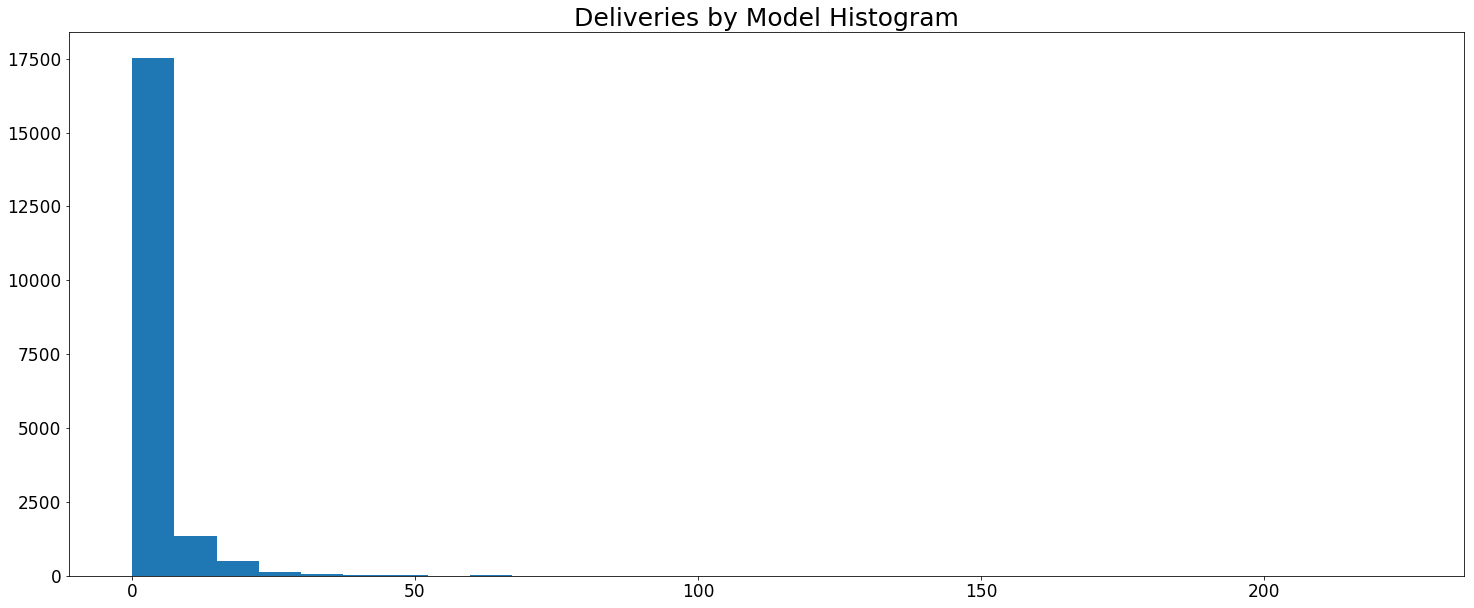

In [14]:
# Target variable distribution
plt.rcParams['figure.figsize'] = (25, 10)
plt.hist(df['Deliveries'], bins=30)
plt.title('Deliveries by Model Histogram', fontsize=25)
plt.tick_params(labelsize=17)
plt.show()

In [15]:
# Group by quarter
total_del = df.groupby('date')['Deliveries'].sum().to_frame('total_del')
total_del.reset_index(inplace=True)
total_del.head()

,date,total_del
0,1970-01-01,42.0
1,1970-04-01,41.0
2,1970-07-01,38.0
3,1970-10-01,205.0
4,1971-01-01,26.0


C:\tools\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\tools\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


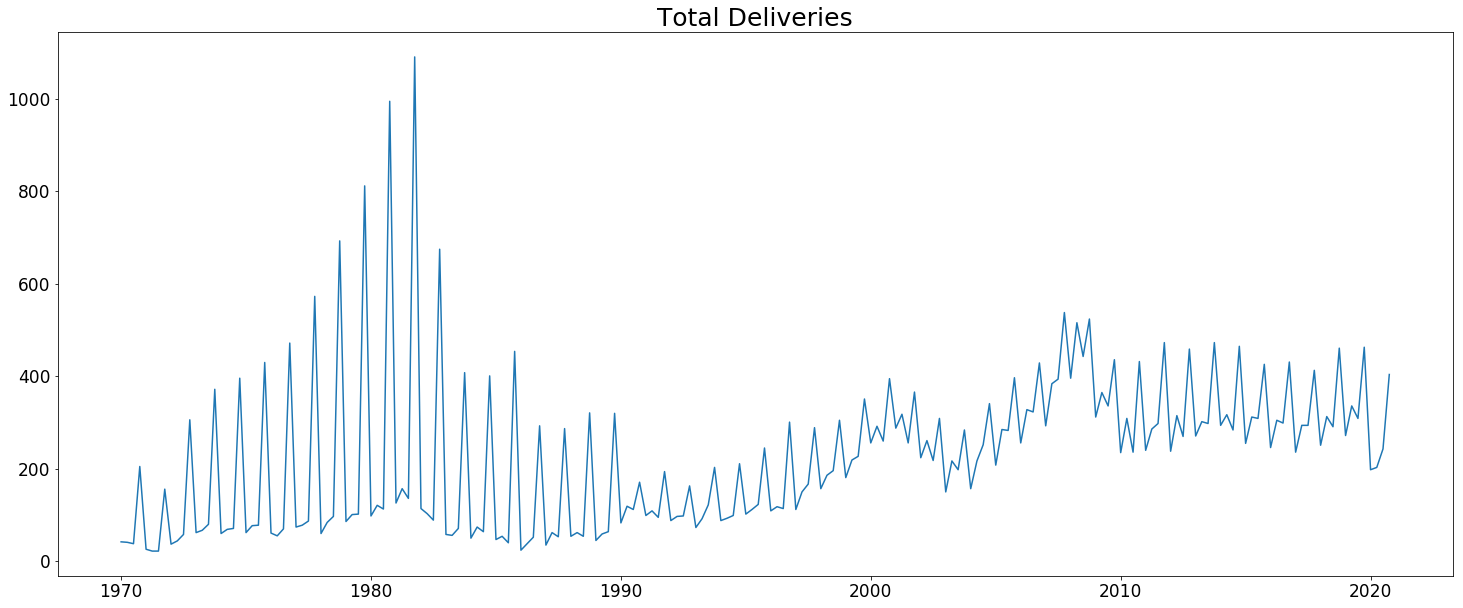

In [16]:
# Total deliveries 
plt.rcParams['figure.figsize'] = (25, 10)
plt.plot(np.array(total_del['date']), total_del['total_del'])
plt.title('Total Deliveries', fontsize=25)
plt.tick_params(labelsize=17)
plt.show()

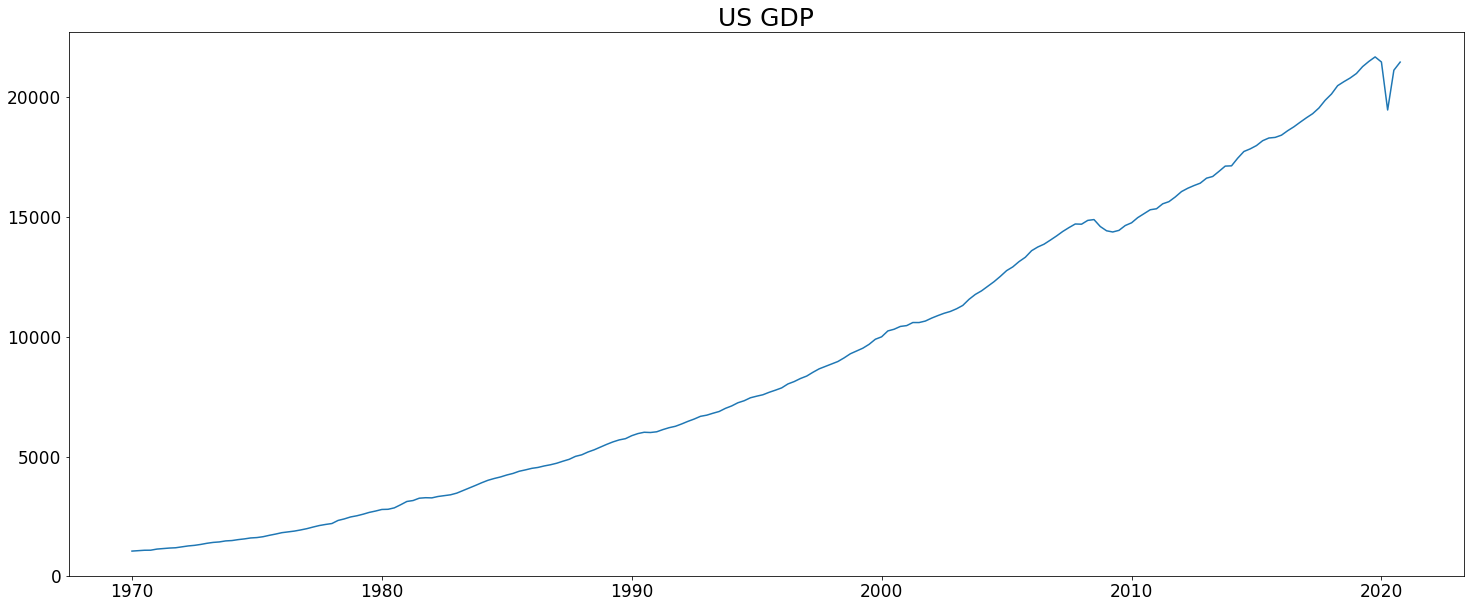

In [17]:
# GDP
plt.rcParams['figure.figsize'] = (25, 10)
plt.plot(np.array(econ['date']), np.array(econ['gdp']))
plt.title('US GDP', fontsize=25)
plt.tick_params(labelsize=17)
plt.show()

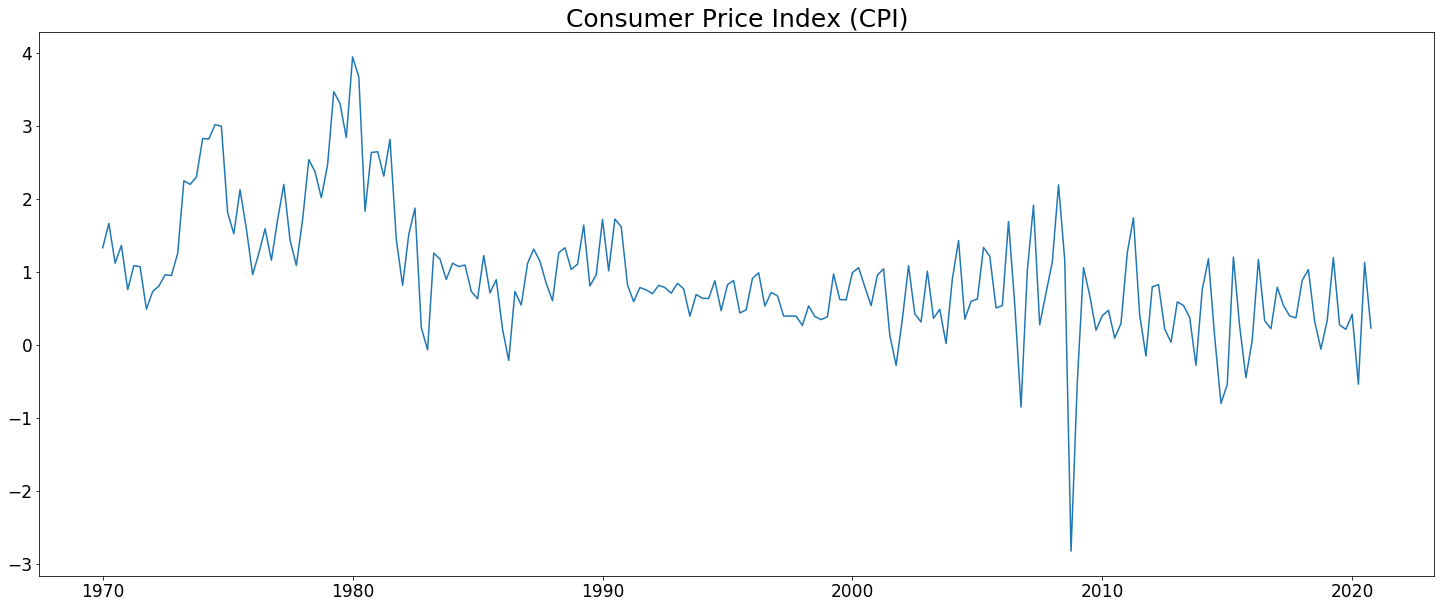

In [18]:
# CPI
plt.rcParams['figure.figsize'] = (25, 10)
plt.plot(np.array(econ['date']), np.array(econ['cpi']))
plt.title('Consumer Price Index (CPI)', fontsize=25)
plt.tick_params(labelsize=17)
plt.show()

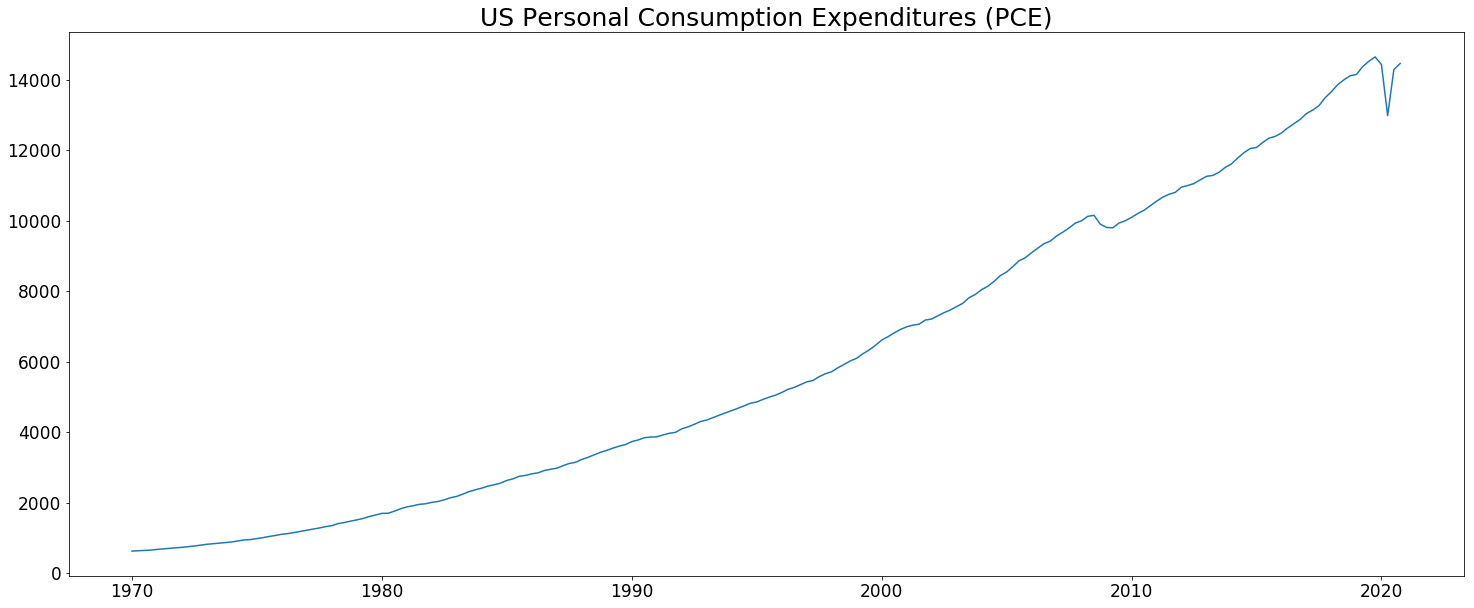

In [19]:
# PCE
plt.rcParams['figure.figsize'] = (25, 10)
plt.plot(np.array(econ['date']), np.array(econ['pce']))
plt.title('US Personal Consumption Expenditures (PCE)', fontsize=25)
plt.tick_params(labelsize=17)
plt.show()

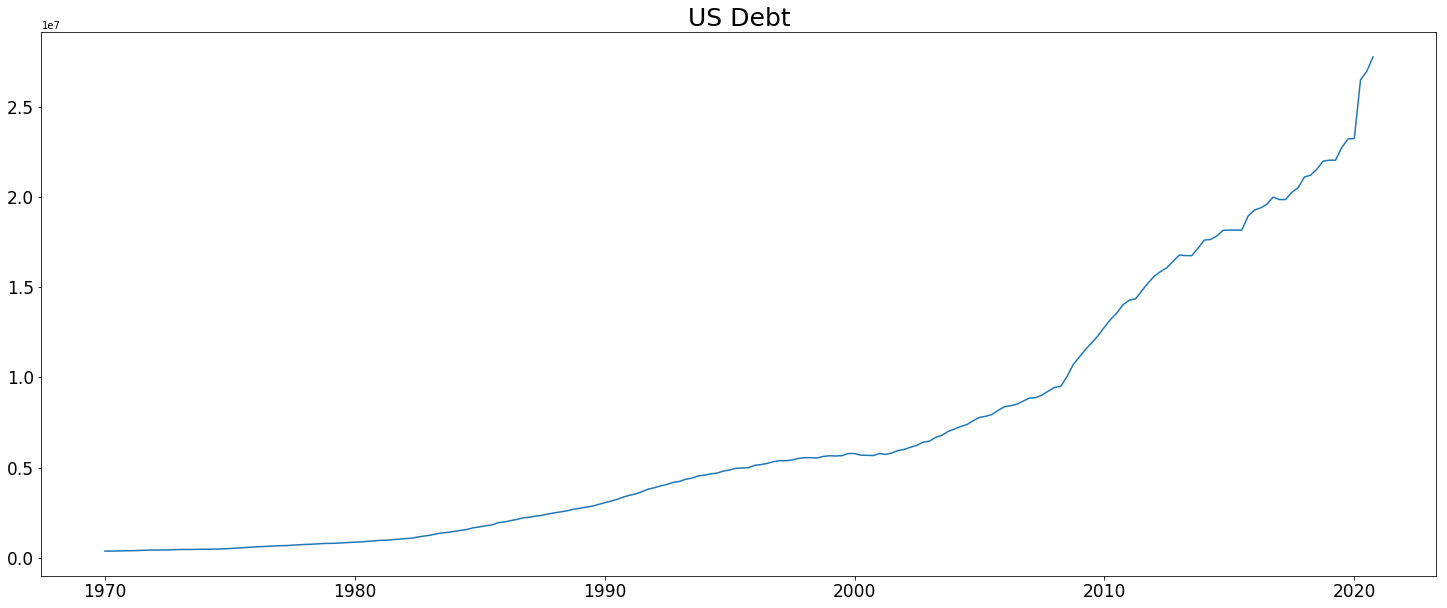

In [20]:
# Debt
plt.rcParams['figure.figsize'] = (25, 10)
plt.plot(np.array(econ['date']), np.array(econ['debt']))
plt.title('US Debt', fontsize=25)
plt.tick_params(labelsize=17)
plt.show()

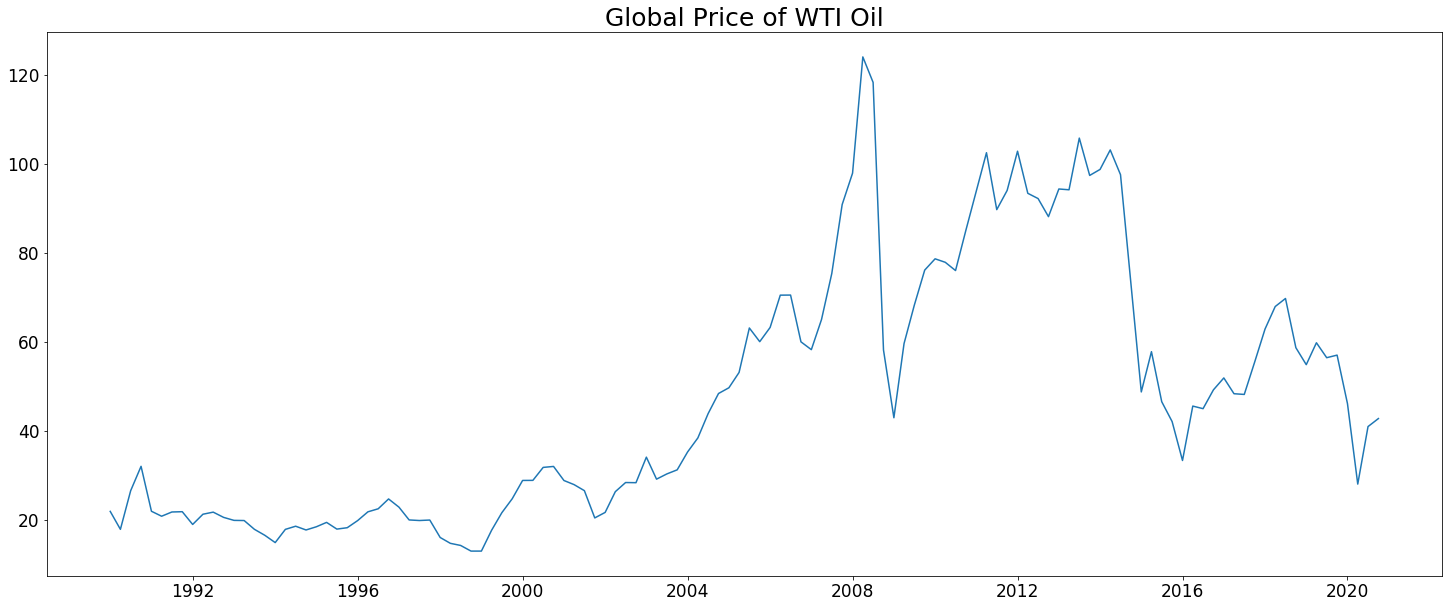

In [21]:
# WTI
plt.rcParams['figure.figsize'] = (25, 10)
plt.plot(np.array(econ['date']), np.array(econ['wti']))
plt.title('Global Price of WTI Oil', fontsize=25)
plt.tick_params(labelsize=17)
plt.show()

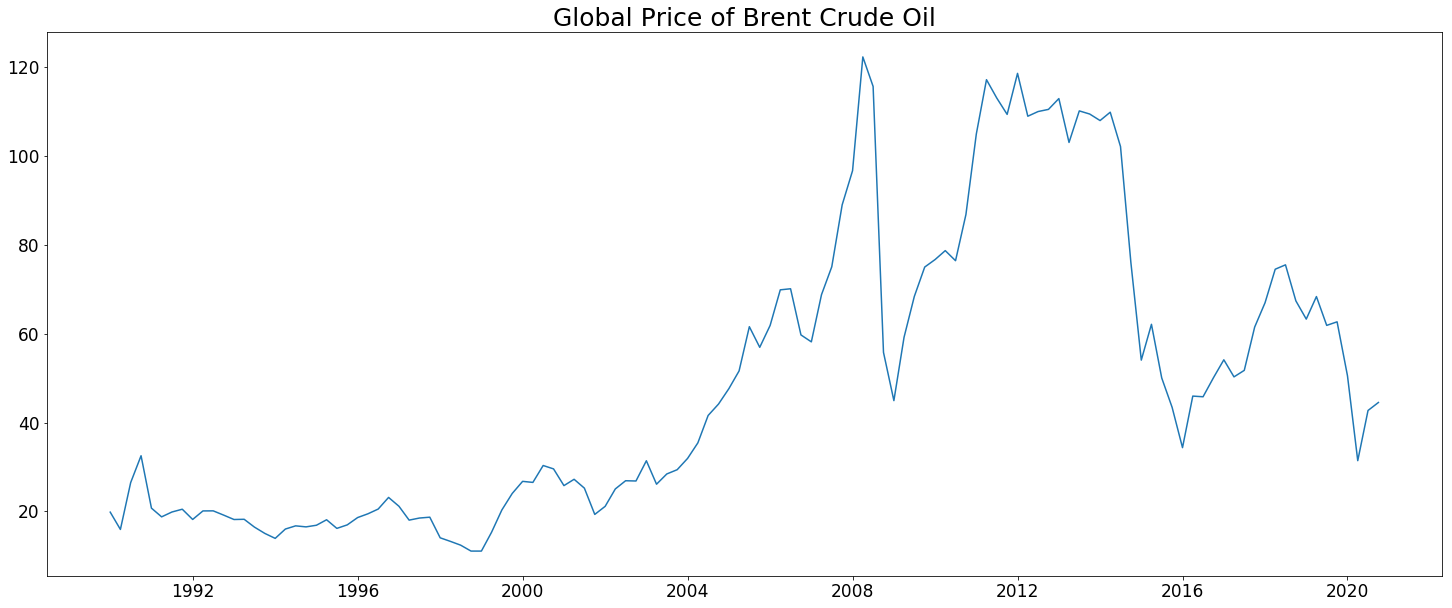

In [22]:
# Brent
plt.rcParams['figure.figsize'] = (25, 10)
plt.plot(np.array(econ['date']), np.array(econ['brent']))
plt.title('Global Price of Brent Crude Oil', fontsize=25)
plt.tick_params(labelsize=17)
plt.show()

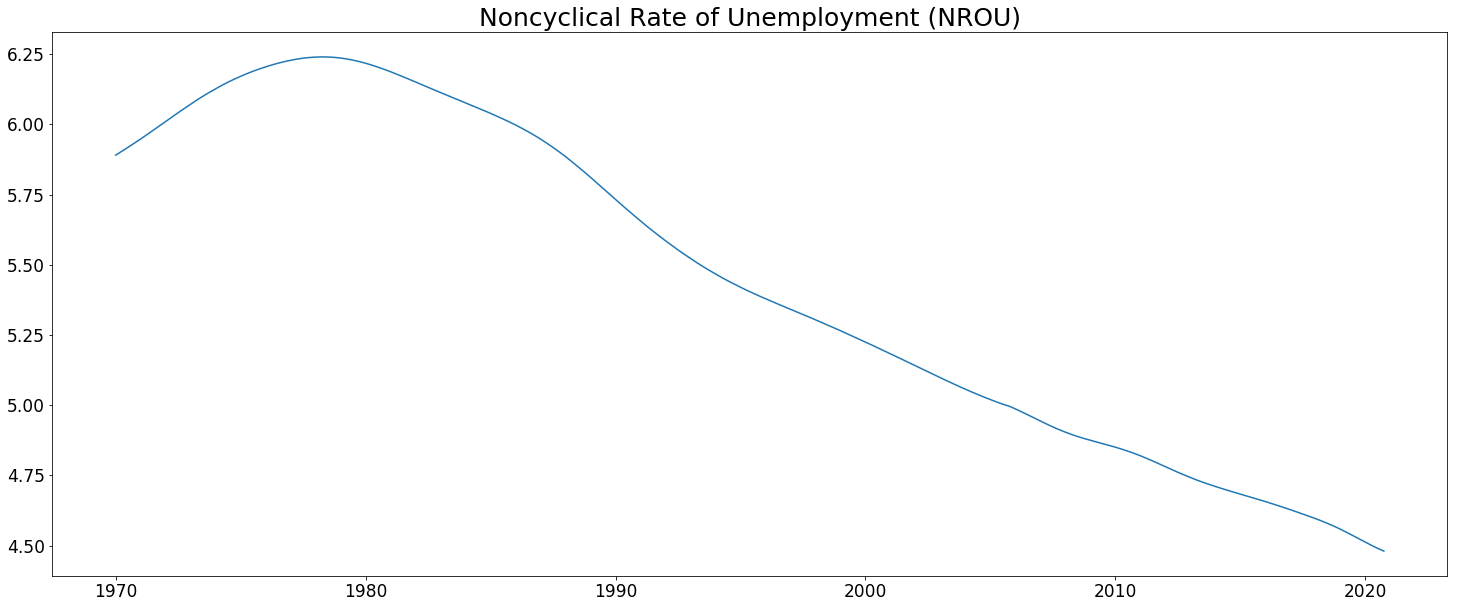

In [23]:
# NROU
plt.rcParams['figure.figsize'] = (25, 10)
plt.plot(np.array(econ['date']), np.array(econ['nrou']))
plt.title('Noncyclical Rate of Unemployment (NROU)', fontsize=25)
plt.tick_params(labelsize=17)
plt.show()

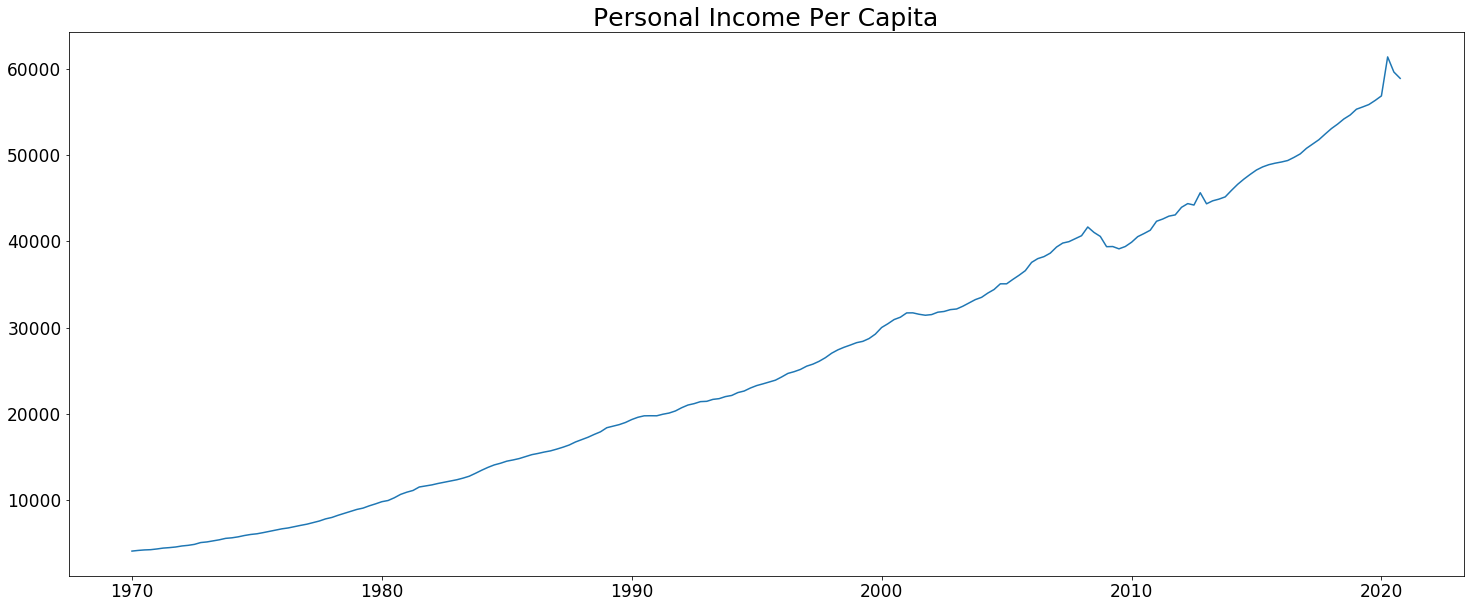

In [24]:
# Personal Income
plt.rcParams['figure.figsize'] = (25, 10)
plt.plot(np.array(econ['date']), np.array(econ['pi']))
plt.title('Personal Income Per Capita', fontsize=25)
plt.tick_params(labelsize=17)
plt.show()

In [25]:
# Make seperate class df's
jet_df = df[df['class'] == 'Jet']
tp_df = df[df['class'] == 'Turboprop']

In [26]:
# Total Jets
jet_sum = jet_df.groupby('date')['Deliveries'].sum().to_frame('jet_del')
jet_sum.reset_index(inplace=True)
jet_sum.head()

,date,jet_del
0,1970-01-01,42.0
1,1970-04-01,41.0
2,1970-07-01,38.0
3,1970-10-01,21.0
4,1971-01-01,26.0


In [27]:
# Total turboprops
tp_sum = tp_df.groupby('date')['Deliveries'].sum().to_frame('tp_del')
tp_sum.reset_index(inplace=True)
tp_sum.head()

,date,tp_del
0,1970-10-01,184.0
1,1971-10-01,131.0
2,1972-10-01,246.0
3,1973-10-01,302.0
4,1974-10-01,315.0


In [28]:
# Merge sums
df_sum = pd.merge(jet_sum, tp_sum, how='left', on='date')
df_sum = pd.merge(df_sum, econ, how='left', on='date')
df_sum = pd.merge(df_sum, total_del, how='left', on='date')
df_sum['tp_del'] = df_sum['tp_del'].fillna(0)
df_sum.head()

,date,jet_del,tp_del,gdp,cpi,pce,debt,wti,brent,nrou,pi,total_del
0,1970-01-01,42.0,0.0,1051.200,1.333333,631.685,372007,NaN,NaN,5.890298,4124,42.0
1,1970-04-01,41.0,0.0,1067.375,1.666667,641.570,370094,NaN,NaN,5.904100,4201,41.0
2,1970-07-01,38.0,0.0,1086.059,1.121657,653.482,378678,NaN,NaN,5.918292,4258,38.0
3,1970-10-01,21.0,184.0,1088.608,1.365188,660.161,389158,NaN,NaN,5.932861,4287,205.0
4,1971-01-01,26.0,0.0,1135.156,0.757576,679.186,391668,NaN,NaN,5.947782,4371,26.0


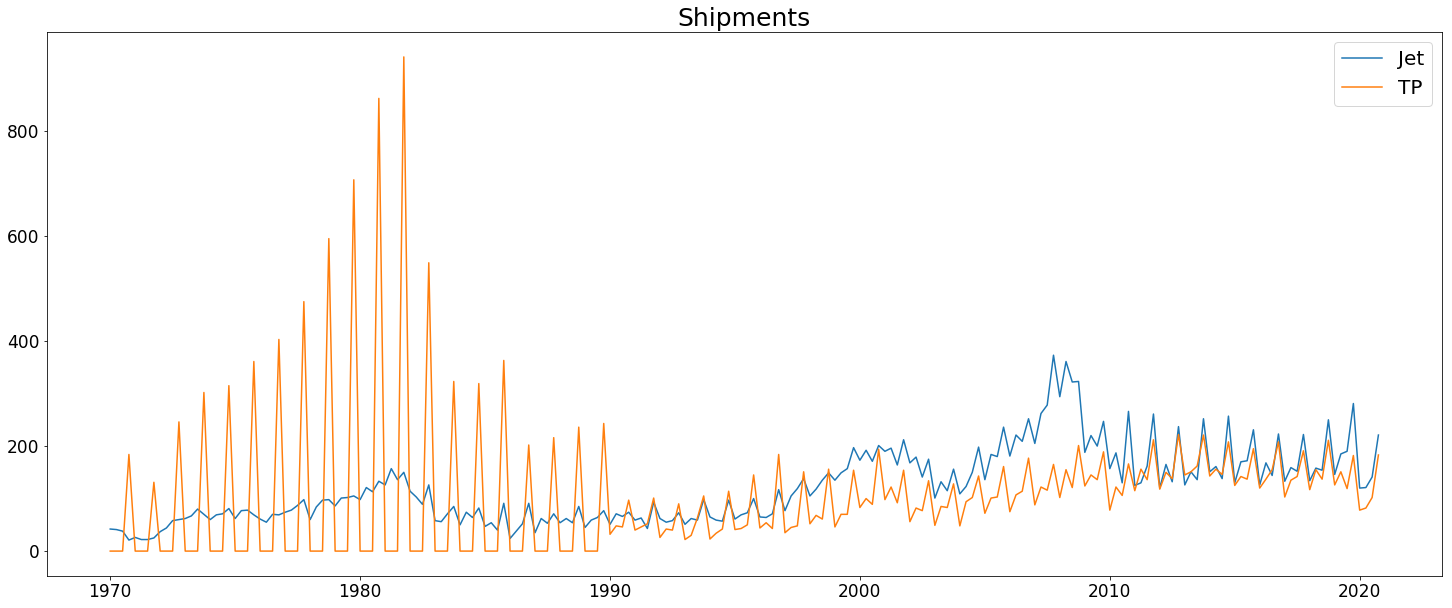

In [29]:
# Shipments by Class
plt.rcParams['figure.figsize'] = (25, 10)
plt.plot(np.array(df_sum['date']), np.array(df_sum['jet_del']), label='Jet')
plt.plot(np.array(df_sum['date']), np.array(df_sum['tp_del']), label='TP')
plt.title('Shipments', fontsize=25)
plt.tick_params(labelsize=17)
plt.legend(fontsize=20)
plt.show()

In [30]:
# Filter date
df_sum2 = df_sum[df_sum['date'] >= '1990-01-01']
print('Filtered Shipment Data')
print(df_sum2.shape)
df_sum2.head()

Filtered Shipment Data
(124, 12)


,date,jet_del,tp_del,gdp,cpi,pce,debt,wti,brent,nrou,pi,total_del
80,1990-01-01,51.0,32.0,5872.701,1.721398,3737.948,3051958,21.830000,19.850000,5.732765,19358,83.0
81,1990-04-01,71.0,48.0,5960.028,1.015361,3783.421,3143754,17.790000,15.960000,5.713231,19620,119.0
82,1990-07-01,66.0,46.0,6015.116,1.726804,3846.700,3233313,26.483333,26.496667,5.693902,19787,112.0
83,1990-10-01,74.0,97.0,6004.733,1.621485,3867.909,3364820,31.966667,32.536667,5.674851,19797,171.0
84,1991-01-01,59.0,40.0,6035.178,0.822737,3873.562,3465189,21.856667,20.750000,5.656146,19791,99.0


In [31]:
df_sum_no_date = df_sum2.drop(['date'], axis=1)
df_sum_no_date.columns=['Jet Shipments', 'TP Shipments', 'GDP', 'CPI', 'PCE', 'DEBT', 'WTI', 'Brent', 'NROU', 'PI', 'All Shipments']
df_sum_no_date.head()

,Jet Shipments,TP Shipments,GDP,CPI,PCE,DEBT,WTI,Brent,NROU,PI,All Shipments
80,51.0,32.0,5872.701,1.721398,3737.948,3051958,21.830000,19.850000,5.732765,19358,83.0
81,71.0,48.0,5960.028,1.015361,3783.421,3143754,17.790000,15.960000,5.713231,19620,119.0
82,66.0,46.0,6015.116,1.726804,3846.700,3233313,26.483333,26.496667,5.693902,19787,112.0
83,74.0,97.0,6004.733,1.621485,3867.909,3364820,31.966667,32.536667,5.674851,19797,171.0
84,59.0,40.0,6035.178,0.822737,3873.562,3465189,21.856667,20.750000,5.656146,19791,99.0


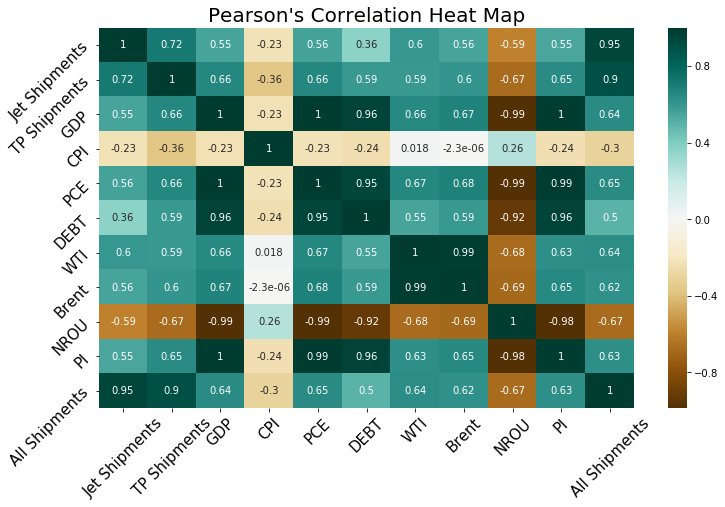

In [32]:
# Plot heat map
c = df_sum_no_date.corr()
plt.figure(figsize=(12,7))
sns.heatmap(c,cmap='BrBG',annot=True)
plt.tick_params(labelsize=15)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.title("Pearson's Correlation Heat Map", fontsize=20)
plt.show()

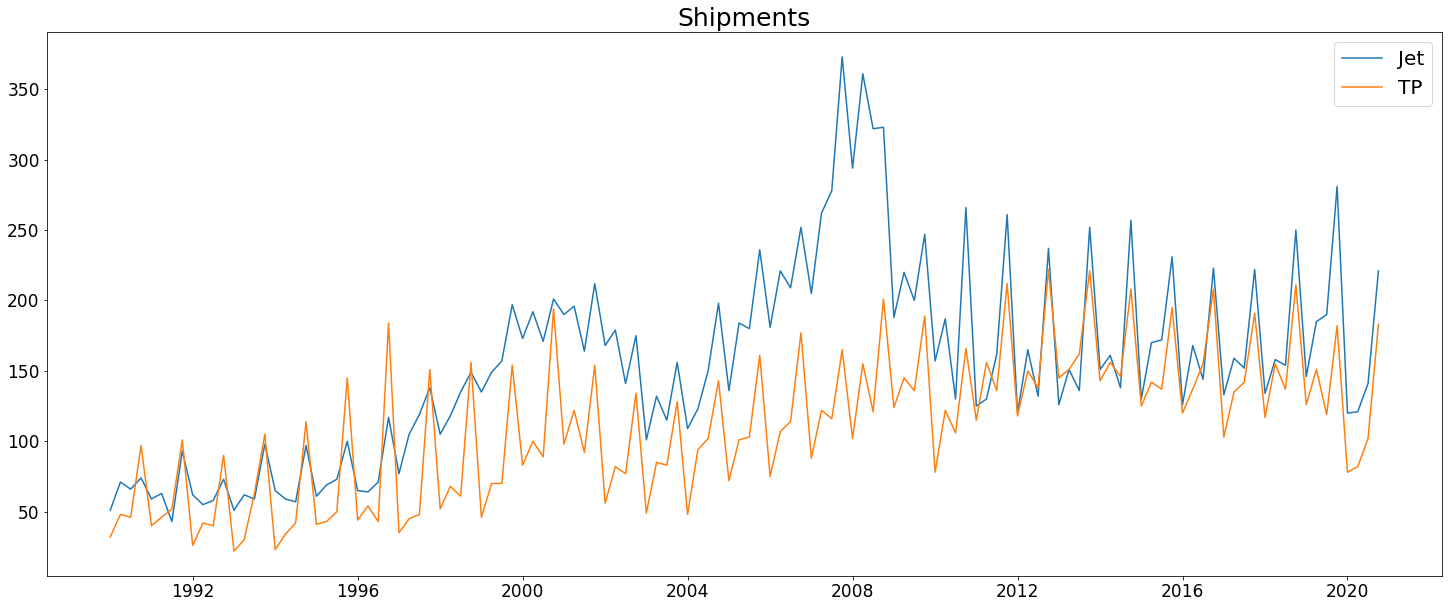

In [33]:
# Plot all shipments
plt.rcParams['figure.figsize'] = (25, 10)
plt.plot(np.array(df_sum2['date']), np.array(df_sum2['jet_del']), label='Jet')
plt.plot(np.array(df_sum2['date']), np.array(df_sum2['tp_del']), label='TP')
plt.title('Shipments', fontsize=25)
plt.tick_params(labelsize=17)
plt.legend(fontsize=20)
plt.show()

In [34]:
df_sum_no_date.head()

,Jet Shipments,TP Shipments,GDP,CPI,PCE,DEBT,WTI,Brent,NROU,PI,All Shipments
80,51.0,32.0,5872.701,1.721398,3737.948,3051958,21.830000,19.850000,5.732765,19358,83.0
81,71.0,48.0,5960.028,1.015361,3783.421,3143754,17.790000,15.960000,5.713231,19620,119.0
82,66.0,46.0,6015.116,1.726804,3846.700,3233313,26.483333,26.496667,5.693902,19787,112.0
83,74.0,97.0,6004.733,1.621485,3867.909,3364820,31.966667,32.536667,5.674851,19797,171.0
84,59.0,40.0,6035.178,0.822737,3873.562,3465189,21.856667,20.750000,5.656146,19791,99.0


In [39]:
# Add lags
df_sum2['lag1'] = df_sum2['total_del'].shift(-1)  # 3 mos
df_sum2['lag2'] = df_sum2['total_del'].shift(-2)  # 6 mos
df_sum2['lag3'] = df_sum2['total_del'].shift(-3)  # 9 mos
df_sum2['lag4'] = df_sum2['total_del'].shift(-4)  # 12 mos
df_sum2['lag5'] = df_sum2['total_del'].shift(-5)  # 15 mos
df_sum2['lag6'] = df_sum2['total_del'].shift(-6)  # 18 mos
df_sum2['lag7'] = df_sum2['total_del'].shift(-7)  # 21 mos
df_sum2['lag8'] = df_sum2['total_del'].shift(-8)  # 24 mos
df_sum2.head()

C:\tools\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\tools\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\tools\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

,date,jet_del,tp_del,gdp,cpi,pce,debt,wti,brent,nrou,pi,total_del,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8
80,1990-01-01,51.0,32.0,5872.701,1.721398,3737.948,3051958,21.830000,19.850000,5.732765,19358,83.0,119.0,112.0,171.0,99.0,109.0,95.0,194.0,88.0
81,1990-04-01,71.0,48.0,5960.028,1.015361,3783.421,3143754,17.790000,15.960000,5.713231,19620,119.0,112.0,171.0,99.0,109.0,95.0,194.0,88.0,97.0
82,1990-07-01,66.0,46.0,6015.116,1.726804,3846.700,3233313,26.483333,26.496667,5.693902,19787,112.0,171.0,99.0,109.0,95.0,194.0,88.0,97.0,98.0
83,1990-10-01,74.0,97.0,6004.733,1.621485,3867.909,3364820,31.966667,32.536667,5.674851,19797,171.0,99.0,109.0,95.0,194.0,88.0,97.0,98.0,163.0
84,1991-01-01,59.0,40.0,6035.178,0.822737,3873.562,3465189,21.856667,20.750000,5.656146,19791,99.0,109.0,95.0,194.0,88.0,97.0,98.0,163.0,73.0


In [40]:
# Move date to index
df_sum3 = df_sum2.copy()
df_sum3 = df_sum3.set_index('date')
df_sum3['date'] = np.arange(len(df_sum2.index))
df_sum3.head()

,jet_del,tp_del,gdp,cpi,pce,debt,wti,brent,nrou,pi,total_del,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,date
date,,,,,,,,,,,,,,,,,,,,
1990-01-01,51.0,32.0,5872.701,1.721398,3737.948,3051958,21.830000,19.850000,5.732765,19358,83.0,119.0,112.0,171.0,99.0,109.0,95.0,194.0,88.0,0
1990-04-01,71.0,48.0,5960.028,1.015361,3783.421,3143754,17.790000,15.960000,5.713231,19620,119.0,112.0,171.0,99.0,109.0,95.0,194.0,88.0,97.0,1
1990-07-01,66.0,46.0,6015.116,1.726804,3846.700,3233313,26.483333,26.496667,5.693902,19787,112.0,171.0,99.0,109.0,95.0,194.0,88.0,97.0,98.0,2
1990-10-01,74.0,97.0,6004.733,1.621485,3867.909,3364820,31.966667,32.536667,5.674851,19797,171.0,99.0,109.0,95.0,194.0,88.0,97.0,98.0,163.0,3
1991-01-01,59.0,40.0,6035.178,0.822737,3873.562,3465189,21.856667,20.750000,5.656146,19791,99.0,109.0,95.0,194.0,88.0,97.0,98.0,163.0,73.0,4


In [41]:
df_sum3 = df_sum3.dropna()
df_sum3.head()

,jet_del,tp_del,gdp,cpi,pce,debt,wti,brent,nrou,pi,total_del,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,date
date,,,,,,,,,,,,,,,,,,,,
1990-01-01,51.0,32.0,5872.701,1.721398,3737.948,3051958,21.830000,19.850000,5.732765,19358,83.0,119.0,112.0,171.0,99.0,109.0,95.0,194.0,88.0,0
1990-04-01,71.0,48.0,5960.028,1.015361,3783.421,3143754,17.790000,15.960000,5.713231,19620,119.0,112.0,171.0,99.0,109.0,95.0,194.0,88.0,97.0,1
1990-07-01,66.0,46.0,6015.116,1.726804,3846.700,3233313,26.483333,26.496667,5.693902,19787,112.0,171.0,99.0,109.0,95.0,194.0,88.0,97.0,98.0,2
1990-10-01,74.0,97.0,6004.733,1.621485,3867.909,3364820,31.966667,32.536667,5.674851,19797,171.0,99.0,109.0,95.0,194.0,88.0,97.0,98.0,163.0,3
1991-01-01,59.0,40.0,6035.178,0.822737,3873.562,3465189,21.856667,20.750000,5.656146,19791,99.0,109.0,95.0,194.0,88.0,97.0,98.0,163.0,73.0,4


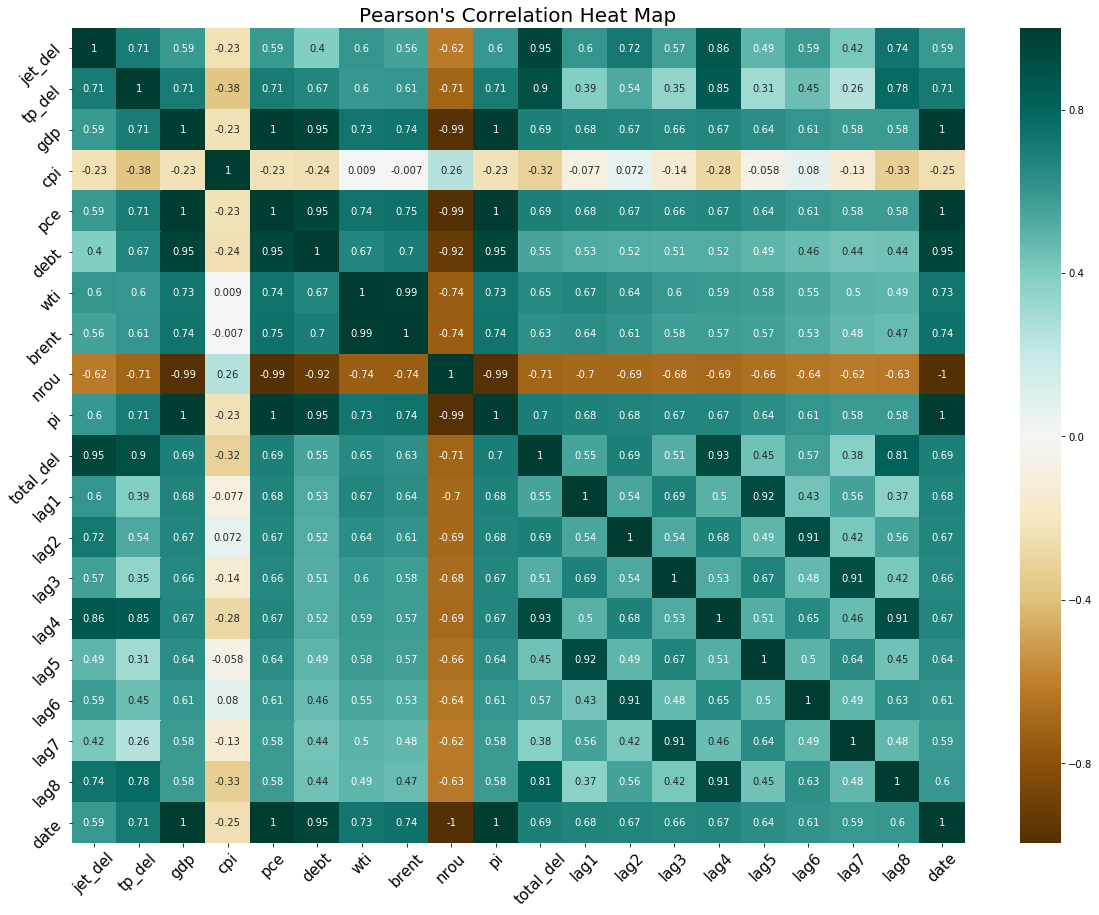

In [42]:
# Plot heat map
c = df_sum3.corr()
plt.figure(figsize=(20,15))
sns.heatmap(c,cmap='BrBG',annot=True)
plt.tick_params(labelsize=15)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.title("Pearson's Correlation Heat Map", fontsize=20)
plt.show()

In [38]:
df_sum2.head()

,date,jet_del,tp_del,gdp,cpi,pce,debt,wti,brent,nrou,pi,total_del
80,1990-01-01,51.0,32.0,5872.701,1.721398,3737.948,3051958,21.830000,19.850000,5.732765,19358,83.0
81,1990-04-01,71.0,48.0,5960.028,1.015361,3783.421,3143754,17.790000,15.960000,5.713231,19620,119.0
82,1990-07-01,66.0,46.0,6015.116,1.726804,3846.700,3233313,26.483333,26.496667,5.693902,19787,112.0
83,1990-10-01,74.0,97.0,6004.733,1.621485,3867.909,3364820,31.966667,32.536667,5.674851,19797,171.0
84,1991-01-01,59.0,40.0,6035.178,0.822737,3873.562,3465189,21.856667,20.750000,5.656146,19791,99.0


In [40]:
df_sum3 = df_sum2.copy()
df_sum3 = df_sum3.set_index('date')
df_sum3['date'] = np.arange(len(df_sum2.index))
df_sum3.head()

,jet_del,tp_del,gdp,cpi,pce,debt,wti,brent,nrou,pi,total_del,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,date
date,,,,,,,,,,,,,,,,,,,,
1990-01-01,51.0,32.0,5872.701,1.721398,3737.948,3051958,21.830000,19.850000,5.732765,19358,83.0,119.0,112.0,171.0,99.0,109.0,95.0,194.0,88.0,0
1990-04-01,71.0,48.0,5960.028,1.015361,3783.421,3143754,17.790000,15.960000,5.713231,19620,119.0,112.0,171.0,99.0,109.0,95.0,194.0,88.0,97.0,1
1990-07-01,66.0,46.0,6015.116,1.726804,3846.700,3233313,26.483333,26.496667,5.693902,19787,112.0,171.0,99.0,109.0,95.0,194.0,88.0,97.0,98.0,2
1990-10-01,74.0,97.0,6004.733,1.621485,3867.909,3364820,31.966667,32.536667,5.674851,19797,171.0,99.0,109.0,95.0,194.0,88.0,97.0,98.0,163.0,3
1991-01-01,59.0,40.0,6035.178,0.822737,3873.562,3465189,21.856667,20.750000,5.656146,19791,99.0,109.0,95.0,194.0,88.0,97.0,98.0,163.0,73.0,4


In [41]:
df_sum4 = df_sum3[['total_del','gdp','pce','wti','brent','nrou','pi']]
df_sum4.head()

,total_del,gdp,pce,wti,brent,nrou,pi
date,,,,,,,
1990-01-01,83.0,5872.701,3737.948,21.830000,19.850000,5.732765,19358
1990-04-01,119.0,5960.028,3783.421,17.790000,15.960000,5.713231,19620
1990-07-01,112.0,6015.116,3846.700,26.483333,26.496667,5.693902,19787
1990-10-01,171.0,6004.733,3867.909,31.966667,32.536667,5.674851,19797
1991-01-01,99.0,6035.178,3873.562,21.856667,20.750000,5.656146,19791


In [42]:
df_sum4.to_csv('gama_ts.csv')

## Linear Regression Model 1

In [44]:
# Training data
X = df_sum3.loc[:, ['date', 'gdp','pce','wti','brent','nrou','pi']]  # features
y = df_sum3.loc[:, 'total_del']  # target

In [45]:
# Split
X_test = X[X['date'] >= 88]
X_train = X[X['date'] < 88]

In [46]:
# Split
y_test = df_sum3[df_sum3['date'] >= 88]
y_test = y_test.loc[:, 'total_del'] 
y_train = df_sum3[df_sum3['date'] < 88]
y_train = y_train.loc[:, 'total_del'] 

In [47]:
# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [48]:
# Store the fitted values as a time series with the same time index as
# the training data
y_pred = pd.Series(model.predict(X_test), index=X_test.index)

In [49]:
results = model.fit(X_train, y_train)

In [84]:
print("Mean absolute error =", round(smt.mean_absolute_error(y_test, y_pred), 4)) 
print("Mean squared error =", round(smt.mean_squared_error(y_test, y_pred), 4)) 
print("Median absolute error =", round(smt.median_absolute_error(y_test, y_pred), 4)) 
print("Explain variance score =", round(smt.explained_variance_score(y_test, y_pred), 4)) 
print("R2 score =", round(smt.r2_score(y_test, y_pred), 4))

Mean absolute error = 215.6175
Mean squared error = 75689.1282
Median absolute error = 181.6919
Explain variance score = -4.279
R2 score = -11.4106


In [53]:
y_pred = pd.DataFrame(y_pred)
y_test = pd.DataFrame(y_test)

In [54]:
y_test = pd.DataFrame(y_test)
y_test.columns = ['Test']
y_pred = pd.DataFrame(y_pred)
y_pred.columns = ['Prediction']

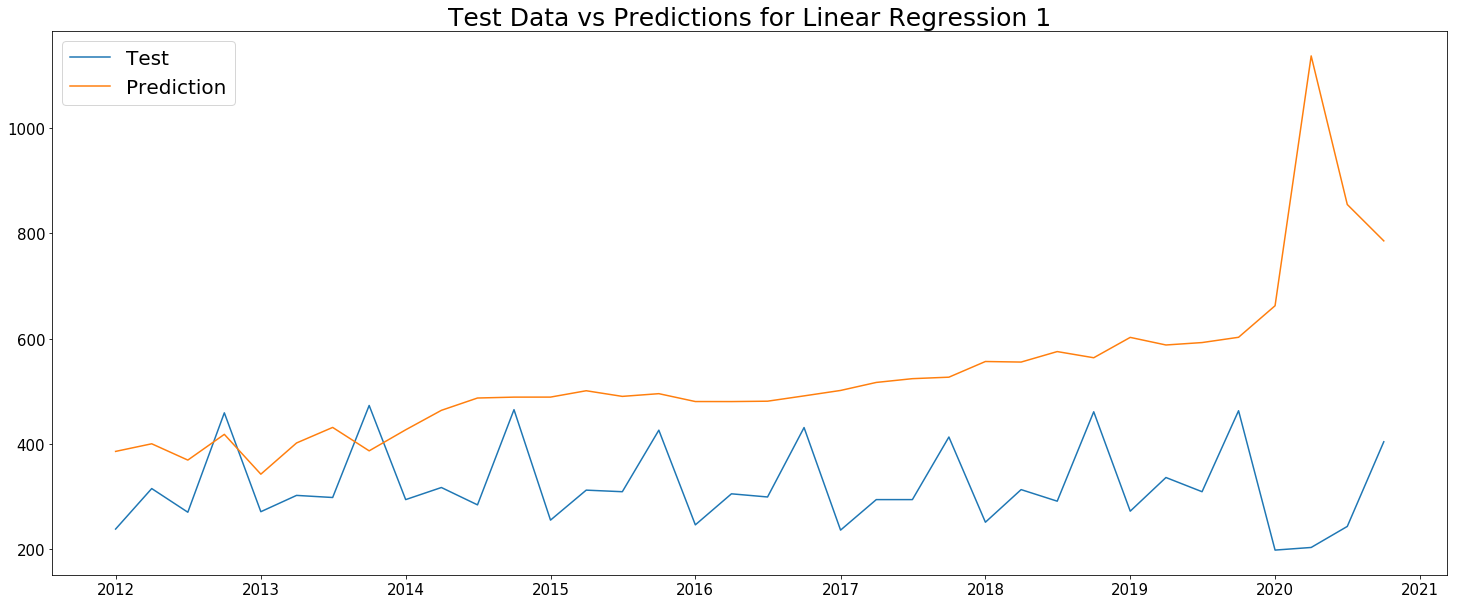

In [56]:
plt.rcParams['figure.figsize'] = (25, 10)
plt.plot(y_test, label = "Test")
plt.plot(y_pred, label = "Prediction")
plt.title('Test Data vs Predictions for Linear Regression 1', fontsize=25)
plt.legend(fontsize=20)
plt.tick_params(labelsize=15)
plt.show()

In [58]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 88 entries, 1990-01-01 to 2011-10-01
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    88 non-null     int32  
 1   gdp     88 non-null     float64
 2   pce     88 non-null     float64
 3   wti     88 non-null     float64
 4   brent   88 non-null     float64
 5   nrou    88 non-null     float64
 6   pi      88 non-null     int64  
dtypes: float64(5), int32(1), int64(1)
memory usage: 5.2 KB


In [59]:
y_train_df = pd.DataFrame(y_train)

In [60]:
y_train_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 88 entries, 1990-01-01 to 2011-10-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   total_del  88 non-null     float64
dtypes: float64(1)
memory usage: 1.4 KB


In [61]:
# Run model
results = sm.OLS(y_train_df,X_train).fit()
results.summary()  

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              total_del   R-squared (uncentered):                   0.949
Model:                            OLS   Adj. R-squared (uncentered):              0.945
Method:                 Least Squares   F-statistic:                              216.0
Date:                Thu, 03 Mar 2022   Prob (F-statistic):                    1.24e-49
Time:                        13:32:11   Log-Likelihood:                         -486.21
No. Observations:                  88   AIC:                                      986.4
Df Residuals:                      81   BIC:                                      1004.
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
date          -5.6252      4.002     -1.405      0.164     -13.589       2.338
gdp            0.0328      0.101      0.323      0.748      -0.169       0.235
pce           -0.1677      0.135     -1.244      0.217      -0.436       0.101
wti            4.7551      2.422      1.963      0.053      -0.064       9.575
brent         -3.9497      2.076     -1.902      0.061      -8.081       0.182
nrou        -120.8502     32.535     -3.714      0.000    -185.585     -56.115
pi             0.0625      0.017      3.672      0.000       0.029       0.096
==============================================================================
Omnibus:                        5.029   Durbin-Watson:                   2.415
Prob(Omnibus):                  0.081   Jarque-Bera (JB):                5.030
Skew:                           0.551   Prob(JB):                       0.0809
Kurtosis:                       2.602   Cond. No.                     1.66e+05
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.66e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [76]:
X_train2 = X_train.drop(['date', 'gdp', 'pce', 'brent'],axis=1)

In [77]:
X_train2.head()

,wti,nrou,pi
date,,,
1990-01-01,21.830000,5.732765,19358
1990-04-01,17.790000,5.713231,19620
1990-07-01,26.483333,5.693902,19787
1990-10-01,31.966667,5.674851,19797
1991-01-01,21.856667,5.656146,19791


In [75]:
X_test2 = X_test.drop(['date', 'gdp', 'pce', 'brent'],axis=1)

In [78]:
# Run model
results = sm.OLS(y_train_df,X_train2).fit()
results.summary()  

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              total_del   R-squared (uncentered):                   0.935
Model:                            OLS   Adj. R-squared (uncentered):              0.933
Method:                 Least Squares   F-statistic:                              406.3
Date:                Thu, 03 Mar 2022   Prob (F-statistic):                    2.89e-50
Time:                        15:08:38   Log-Likelihood:                         -497.15
No. Observations:                  88   AIC:                                      1000.
Df Residuals:                      85   BIC:                                      1008.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
wti            0.3981      0.515      0.772      0.442      -0.627       1.423
nrou         -18.9523      6.824     -2.777      0.007     -32.519      -5.385
pi             0.0106      0.002      6.342      0.000       0.007       0.014
==============================================================================
Omnibus:                        1.453   Durbin-Watson:                   1.937
Prob(Omnibus):                  0.483   Jarque-Bera (JB):                1.421
Skew:                           0.298   Prob(JB):                        0.491
Kurtosis:                       2.823   Cond. No.                     2.89e+04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 2.89e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

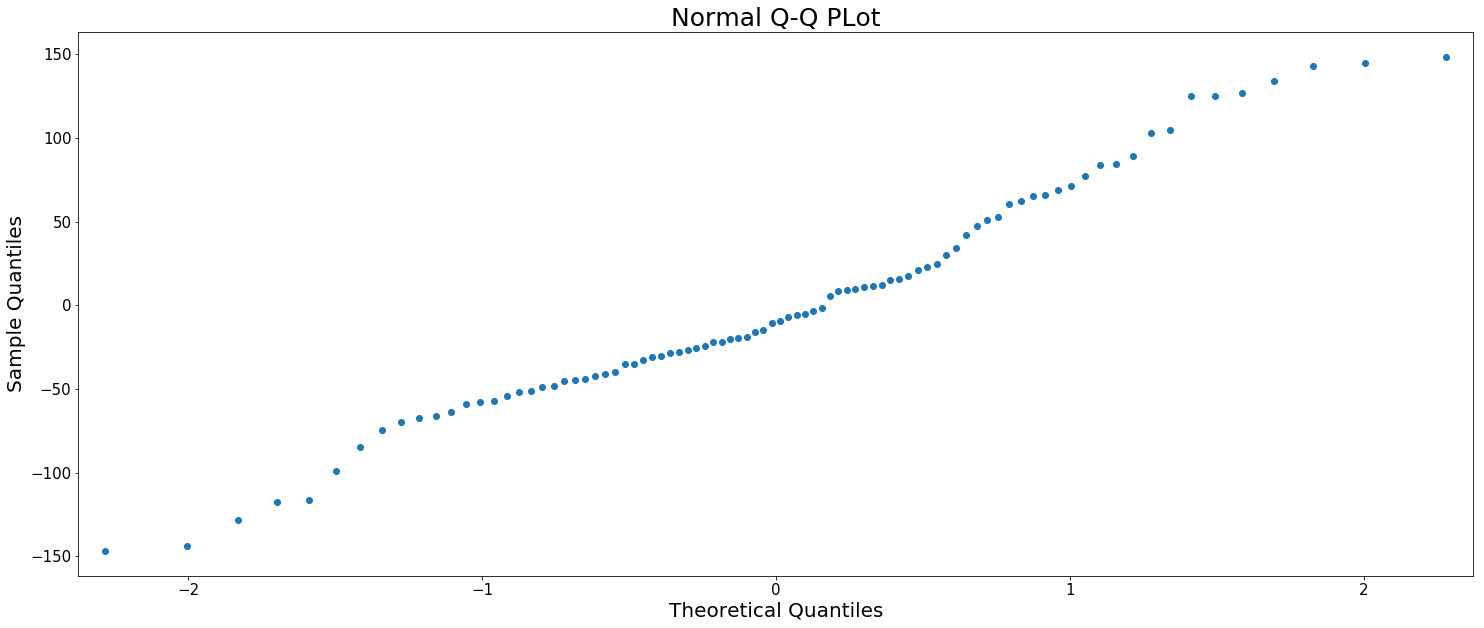

In [66]:
# Check residuals 
plt.rcParams['figure.figsize'] = (25, 10)
residuals = results.resid
sm.qqplot(residuals)
plt.title('Normal Q-Q PLot', fontsize=25)
plt.xlabel('Theoretical Quantiles', fontsize=20)
plt.ylabel('Sample Quantiles', fontsize=20)
plt.tick_params(labelsize=15)
plt.show()

In [67]:
preds = results.predict(X_test2)

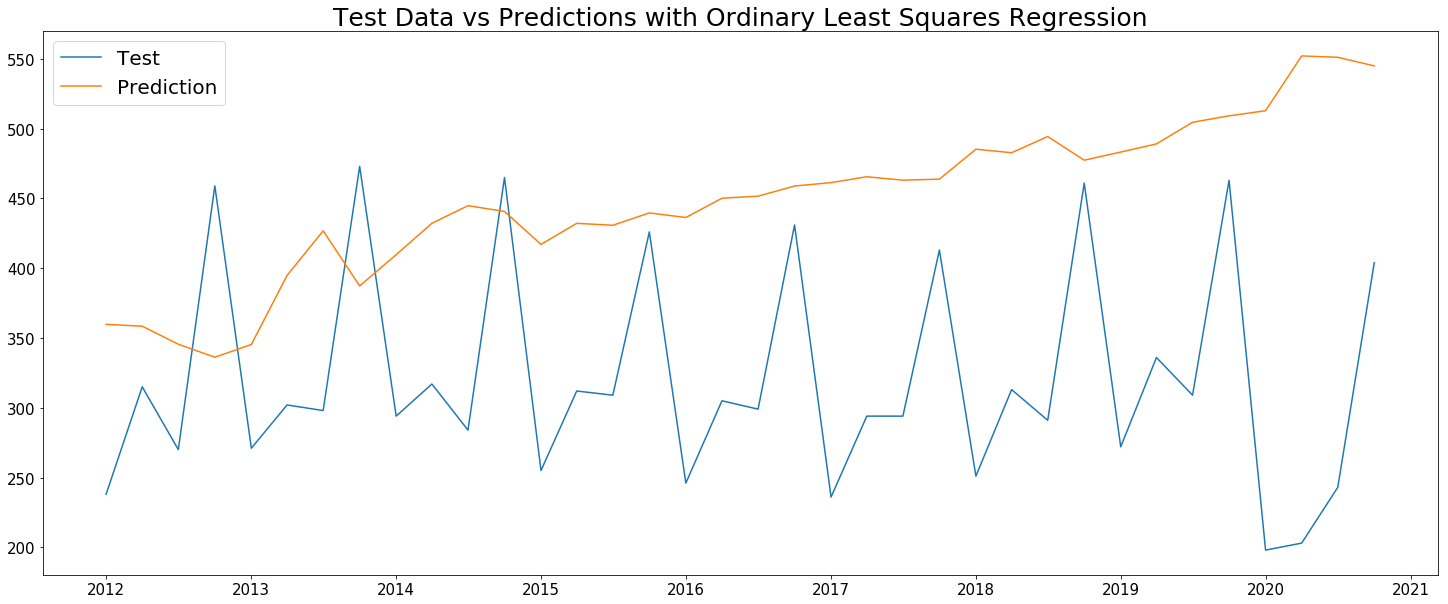

In [102]:
plt.rcParams['figure.figsize'] = (25, 10)
plt.plot(y_test, label = "Test")
plt.plot(preds, label = "Prediction")
plt.title('Test Data vs Predictions with Ordinary Least Squares Regression', fontsize=25)
plt.legend(fontsize=20)
plt.tick_params(labelsize=15)
plt.show()

In [85]:
print("Mean absolute error =", round(smt.mean_absolute_error(y_test, preds), 4)) 
print("Mean squared error =", round(smt.mean_squared_error(y_test, preds), 4)) 
print("Median absolute error =", round(smt.median_absolute_error(y_test, preds), 4)) 
print("Explain variance score =", round(smt.explained_variance_score(y_test, preds), 4)) 
print("R2 score =", round(smt.r2_score(y_test, preds), 4))

Mean absolute error = 140.3968
Mean squared error = 26296.3255
Median absolute error = 134.883
Explain variance score = -0.6478
R2 score = -3.3118


In [98]:
from sklearn.linear_model import ElasticNet
clf = ElasticNet(random_state=0)
clf.fit(X_train2, y_train)

ElasticNet(random_state=0)

In [99]:
ridge_pred = pd.Series(clf.predict(X_test2), index=X_test2.index)

In [100]:
print("Mean absolute error =", round(smt.mean_absolute_error(y_test, ridge_pred), 4)) 
print("Mean squared error =", round(smt.mean_squared_error(y_test, ridge_pred), 4)) 
print("Median absolute error =", round(smt.median_absolute_error(y_test, ridge_pred), 4)) 
print("Explain variance score =", round(smt.explained_variance_score(y_test, ridge_pred), 4)) 
print("R2 score =", round(smt.r2_score(y_test, ridge_pred), 4))

Mean absolute error = 164.8316
Mean squared error = 34865.9451
Median absolute error = 160.63
Explain variance score = -0.5102
R2 score = -4.7169


In [69]:
%%capture --no-display

# Initialize model
rforest = RandomForestRegressor()

# Parameters to search
#RandomForestClassifier().get_params().keys()
rforest_space = dict()
rforest_space['bootstrap'] = [True, False]
rforest_space['max_features'] = ['auto', 'sqrt']
rforest_space['max_depth'] = [10, 20, 30, 40, 50, None] #, 60, 70, 80, 90, 100,
rforest_space['min_samples_split'] = [2, 5, 10]
rforest_space['min_samples_leaf'] = [1, 2, 4]
rforest_space['n_estimators'] = [100, 200, 400, 600, 800, 1000] #, 1200, 1400, 1600, 1800, 2000

# Randomized search
rforest_rscv = RandomizedSearchCV(rforest, rforest_space, n_iter=500, cv=3, scoring='accuracy')

# Search for best model
rforest_hp1 = rforest_rscv.fit(X_train, y_train)

# Fit model
rforest_hp1.fit(X_train, y_train)

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=500,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 400, 600,
                                                         800, 1000]},
                   scoring='accuracy')

In [70]:
# Predict
rforest_pred = pd.Series(rforest_hp1.predict(X_test), index=X_test.index)
#rforest_pred = rforest_hp1.predict(X_test)
#print('rforest_hp1 - Random Forest\n')

In [71]:
rforest_pred_df = pd.DataFrame(rforest_pred, columns=['pred'])
rforest_pred_df.head()

,pred
date,
2012-01-01,325.040774
2012-04-01,325.088829
2012-07-01,325.088829
2012-10-01,324.462163
2013-01-01,325.040774


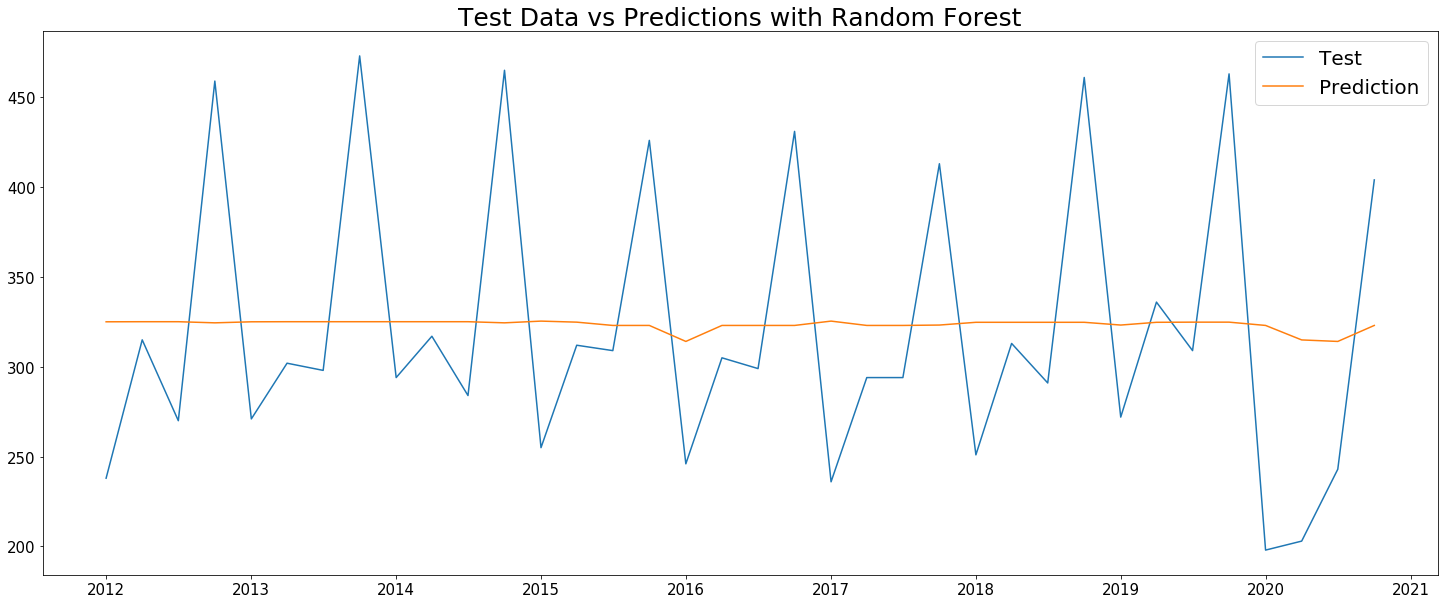

In [101]:
plt.rcParams['figure.figsize'] = (25, 10)
plt.plot(y_test, label = "Test")
plt.plot(rforest_pred_df, label = "Prediction")
plt.title('Test Data vs Predictions with Random Forest', fontsize=25)
plt.legend(fontsize=20)
plt.tick_params(labelsize=15)
plt.show()

In [86]:
# random forest
print("Mean absolute error =", round(smt.mean_absolute_error(y_test, rforest_pred), 4)) 
print("Mean squared error =", round(smt.mean_squared_error(y_test, rforest_pred), 4)) 
print("Median absolute error =", round(smt.median_absolute_error(y_test, rforest_pred), 4)) 
print("Explain variance score =", round(smt.explained_variance_score(y_test, rforest_pred), 4)) 
print("R2 score =", round(smt.r2_score(y_test, rforest_pred), 4))

Mean absolute error = 63.2322
Mean squared error = 5982.3044
Median absolute error = 54.5648
Explain variance score = 0.0203
R2 score = 0.0191


In [87]:
# OLS
print("Mean absolute error =", round(smt.mean_absolute_error(y_test, preds), 4)) 
print("Mean squared error =", round(smt.mean_squared_error(y_test, preds), 4)) 
print("Median absolute error =", round(smt.median_absolute_error(y_test, preds), 4)) 
print("Explain variance score =", round(smt.explained_variance_score(y_test, preds), 4)) 
print("R2 score =", round(smt.r2_score(y_test, preds), 4))

Mean absolute error = 140.3968
Mean squared error = 26296.3255
Median absolute error = 134.883
Explain variance score = -0.6478
R2 score = -3.3118


In [88]:
# linear reg
print("Mean absolute error =", round(smt.mean_absolute_error(y_test, y_pred), 4)) 
print("Mean squared error =", round(smt.mean_squared_error(y_test, y_pred), 4)) 
print("Median absolute error =", round(smt.median_absolute_error(y_test, y_pred), 4)) 
print("Explain variance score =", round(smt.explained_variance_score(y_test, y_pred), 4)) 
print("R2 score =", round(smt.r2_score(y_test, y_pred), 4))

Mean absolute error = 215.6175
Mean squared error = 75689.1282
Median absolute error = 181.6919
Explain variance score = -4.279
R2 score = -11.4106
